In [28]:
import os
import sys
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import NMF
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense, Activation
from keras.callbacks import EarlyStopping
from keras import optimizers, utils, initializers

In [29]:
root = "./cropped/"

In [30]:
## Helper Functions

def writeProgress(msg, count, total):
    sys.stdout.write(msg + "{:.2%}\r".format(count/total))
    sys.stdout.flush()

In [31]:
## Original Data Size
print("Calculating original data size ...")

count = 0
heights = []
widths = []
for path, subdirs, files in os.walk(root):
    for name in files:
        if not name.endswith(".jpg"):
            continue
        img_path = os.path.join(path, name)
        img = Image.open(img_path)
        w, h = img.size
        widths.append(w)
        heights.append(h)
        
        count += 1
        writeProgress("Progress calculating: ", count, 1585)

min_height = min(heights)
min_width = min(widths)
total = count

med_height = np.median(heights)
med_width = np.median(widths)

Calculating original data size ...


In [32]:
print("Number of image: ", total)
print("Min image height: ", min_height)
print("Min image width: ", min_width)
print("Median image height: ", med_height)
print("Median image width: ", med_width)

Number of image:  1585
Min image height:  10
Min image width:  24
Median image height:  264.0
Median image width:  419.0


In [33]:
resize_W, resize_H = 200, 200

In [34]:
## Resize and Read image into ndarray

count = 0
images = []
labels = []
for path, subdirs, files in os.walk(root):
#     if not path.endswith("buoy") and not path.endswith("cruise ship"):
#             continue
    
    for (i, name) in enumerate(files):
        if not name.endswith(".jpg"):
            continue
        
        label = os.path.basename(path)
        img_path = os.path.join(path, name)
        img = Image.open(img_path)
        img = img.resize((resize_W, resize_H), Image.ANTIALIAS)
        img = img.convert("L")
        img = np.array(img)
        
        images.append(img)
        labels.append(label)
        
        count += 1
        writeProgress("Progress loading images: ", count, total)


X = np.array(images)
Y = np.array(labels)

In [35]:
## Data Size (after resizing)
print("X shape: ", X.shape)
print("Y size: ", Y.shape)

X shape:  (1585, 200, 200)
Y size:  (1585,)


(200, 200)
Class:  buoy


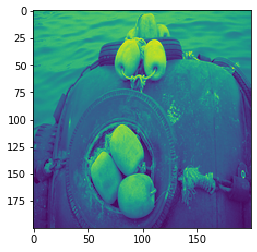

In [36]:
plt.imshow(X[0])
print(X[0].shape)
print("Class: ", Y[0])

In [37]:
## Reshape X for NMF

X_nmf = X.reshape(X.shape[0], -1)

In [38]:
## Reshape Data Y for RNN

onehotEncoder = OneHotEncoder(dtype=np.int)
Y_enc = onehotEncoder.fit_transform(Y.reshape(-1,1))

print(Y_enc.shape)

(1585, 9)


In [39]:
## Split Test/ Train
print("Spliting Test / Train sets ...")

X_train, X_test, y_train, y_test = train_test_split(X_nmf, Y_enc, test_size=0.3, random_state=42)

Spliting Test / Train sets ...


In [40]:
## Data Size (after spliting)
print("X train shape: ", X_train.shape)
print("Y train shape: ", y_train.shape)
print("X test shape: ", X_test.shape)
print("Y test shape: ", y_test.shape)

X train shape:  (1109, 40000)
Y train shape:  (1109, 9)
X test shape:  (476, 40000)
Y test shape:  (476, 9)


In [41]:
## NMF Param
components = 900

In [42]:
## NMF
print("NMF ...")

nmf = NMF(n_components=components, init='random', random_state=0, tol=0.1, verbose=True)

W = nmf.fit_transform(X_train)
H = nmf.components_

NMF ...
violation: 1.0
violation: 0.23651037864934088
violation: 0.1078167252529872
violation: 0.08212152099838123
Converged at iteration 4


In [43]:
X_reduced = W
X_recovered = nmf.inverse_transform(X_reduced)

In [44]:
## Data Size
print("Reduced Shape: " + str(X_reduced.shape))
print("Recovered Shape: " + str(X_recovered.shape))

Reduced Shape: (1109, 900)
Recovered Shape: (1109, 40000)


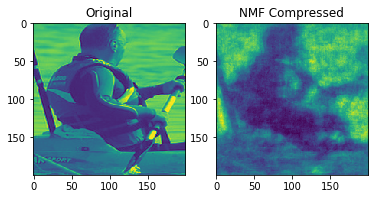

In [45]:
f = plt.figure()
f.add_subplot(1, 2, 1)
plt.title("Original")
plt.imshow(X_train[0].reshape(X.shape[1], X.shape[2]))

f.add_subplot(1,2, 2)
plt.title("NMF Compressed")
plt.imshow(X_recovered[0].reshape(X.shape[1], X.shape[2]))

plt.show(block=True)

In [46]:
## Reshape X for RNN

X_rnn = X_reduced.reshape(X_reduced.shape[0], -1, 1)

X_test_reduced = nmf.transform(X_test)
X_test_rnn = X_test_reduced.reshape(X_test_reduced.shape[0], -1, 1)

violation: 1.0
violation: 0.6502456345727322
violation: 0.4152898232726997
violation: 0.31128375128473507
violation: 0.2594965208958811
violation: 0.22616114913795377
violation: 0.20825494576162068
violation: 0.19400565361677197
violation: 0.18169095462935522
violation: 0.1717959287299979
violation: 0.16201963752474657
violation: 0.15545479319147212
violation: 0.14948568987194855
violation: 0.1434285034995888
violation: 0.1362534504408081
violation: 0.13029154586577127
violation: 0.12517561508000102
violation: 0.1206004874236392
violation: 0.11563599118549787
violation: 0.11084669893248149
violation: 0.10570173245354533
violation: 0.10017571530964803
violation: 0.09660505166250719
Converged at iteration 23


In [47]:
## Model Params
batch_size = 32
num_classes = 9
epochs = 200
hidden_units = 100
learning_rate = 1e-6

In [48]:
## Model: LSTM
def lstm(inputShape):
    model = Sequential()
    model.add(SimpleRNN(hidden_units,
                        kernel_initializer=initializers.RandomNormal(stddev=0.001),
                        recurrent_initializer=initializers.Identity(gain=1.0),
                        activation='relu',
                        input_shape=inputShape[1:]))
    model.add(Dense(num_classes))
    model.add(Activation("softmax"))
    
    rmsprop = optimizers.RMSprop(lr=learning_rate)
    model.compile(optimizer=rmsprop, 
                  loss="categorical_crossentropy", 
                  metrics=['accuracy'])
    return model

model = lstm(X_rnn.shape)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_2 (SimpleRNN)     (None, 100)               10200     
_________________________________________________________________
dense_2 (Dense)              (None, 9)                 909       
_________________________________________________________________
activation_2 (Activation)    (None, 9)                 0         
Total params: 11,109
Trainable params: 11,109
Non-trainable params: 0
_________________________________________________________________


In [49]:
## Model: Early Stopping Conditions

early_stop_loss = EarlyStopping(monitor='loss', patience=3, verbose=1)
early_stop_val_acc = EarlyStopping(monitor='val_acc', patience=3, verbose=1)
model_callbacks = [early_stop_loss, early_stop_val_acc]

In [50]:
## Training

h = model.fit(X_rnn, y_train,
                batch_size=batch_size,
                epochs=epochs,
#                 callbacks=model_callbacks,
                shuffle=True,
                validation_data=(X_test_rnn, y_test))

Train on 1109 samples, validate on 476 samples
Epoch 1/200
1109/1109 [==============================] - 4s 4ms/step - loss: 1.9817 - acc: 0.2723 - val_loss: 1.8351 - val_acc: 0.3550
Epoch 2/200
1109/1109 [==============================] - 4s 4ms/step - loss: 1.8157 - acc: 0.3201 - val_loss: 1.8201 - val_acc: 0.3550
Epoch 3/200
1109/1109 [==============================] - 4s 3ms/step - loss: 1.7916 - acc: 0.3201 - val_loss: 1.8151 - val_acc: 0.3550
Epoch 4/200
1109/1109 [==============================] - 4s 3ms/step - loss: 1.7802 - acc: 0.3201 - val_loss: 1.8062 - val_acc: 0.3550
Epoch 5/200
1109/1109 [==============================] - 4s 4ms/step - loss: 1.7748 - acc: 0.3201 - val_loss: 1.7889 - val_acc: 0.3571
Epoch 6/200
1109/1109 [==============================] - 4s 4ms/step - loss: 1.7692 - acc: 0.3210 - val_loss: 1.7856 - val_acc: 0.3550
Epoch 7/200
1109/1109 [==============================] - 4s 4ms/step - loss: 1.7644 - acc: 0.3309 - val_loss: 1.7862 - val_acc: 0.3550
Epoch 8/

Epoch 61/200
1109/1109 [==============================] - 4s 3ms/step - loss: 1.6723 - acc: 0.3715 - val_loss: 1.7107 - val_acc: 0.3718
Epoch 62/200
1109/1109 [==============================] - 4s 3ms/step - loss: 1.6705 - acc: 0.3787 - val_loss: 1.7012 - val_acc: 0.3908
Epoch 63/200
1109/1109 [==============================] - 4s 4ms/step - loss: 1.6674 - acc: 0.3751 - val_loss: 1.7278 - val_acc: 0.3718
Epoch 64/200
1109/1109 [==============================] - 5s 4ms/step - loss: 1.6685 - acc: 0.3868 - val_loss: 1.6798 - val_acc: 0.4076
Epoch 65/200
1109/1109 [==============================] - 4s 4ms/step - loss: 1.6682 - acc: 0.3814 - val_loss: 1.6809 - val_acc: 0.4286
Epoch 66/200
1109/1109 [==============================] - 4s 4ms/step - loss: 1.6650 - acc: 0.3733 - val_loss: 1.7142 - val_acc: 0.3508
Epoch 67/200
1109/1109 [==============================] - 4s 4ms/step - loss: 1.6702 - acc: 0.3814 - val_loss: 1.6818 - val_acc: 0.4034
Epoch 68/200
1109/1109 [========================

1109/1109 [==============================] - 4s 4ms/step - loss: 1.6406 - acc: 0.3913 - val_loss: 1.6824 - val_acc: 0.3613
Epoch 122/200
1109/1109 [==============================] - 4s 4ms/step - loss: 1.6351 - acc: 0.3931 - val_loss: 1.6735 - val_acc: 0.3950
Epoch 123/200
1109/1109 [==============================] - 4s 4ms/step - loss: 1.6387 - acc: 0.3868 - val_loss: 1.6433 - val_acc: 0.4034
Epoch 124/200
1109/1109 [==============================] - 4s 4ms/step - loss: 1.6373 - acc: 0.3959 - val_loss: 1.7371 - val_acc: 0.3487
Epoch 125/200
1109/1109 [==============================] - 4s 4ms/step - loss: 1.6386 - acc: 0.3913 - val_loss: 1.6448 - val_acc: 0.3971
Epoch 126/200
1109/1109 [==============================] - 4s 4ms/step - loss: 1.6324 - acc: 0.3913 - val_loss: 1.7066 - val_acc: 0.3782
Epoch 127/200
1109/1109 [==============================] - 4s 4ms/step - loss: 1.6401 - acc: 0.3841 - val_loss: 1.6590 - val_acc: 0.3908
Epoch 128/200
1109/1109 [==============================

Epoch 181/200
1109/1109 [==============================] - 5s 4ms/step - loss: 1.6247 - acc: 0.3859 - val_loss: 1.6346 - val_acc: 0.4034
Epoch 182/200
1109/1109 [==============================] - 5s 4ms/step - loss: 1.6176 - acc: 0.3959 - val_loss: 1.8206 - val_acc: 0.3319
Epoch 183/200
1109/1109 [==============================] - 4s 4ms/step - loss: 1.6072 - acc: 0.3940 - val_loss: 1.7396 - val_acc: 0.3256
Epoch 184/200
1109/1109 [==============================] - 4s 4ms/step - loss: 1.6249 - acc: 0.3940 - val_loss: 1.6310 - val_acc: 0.3950
Epoch 185/200
1109/1109 [==============================] - 4s 4ms/step - loss: 1.6203 - acc: 0.3986 - val_loss: 1.7361 - val_acc: 0.3487
Epoch 186/200
1109/1109 [==============================] - 4s 4ms/step - loss: 1.6132 - acc: 0.4058 - val_loss: 1.6365 - val_acc: 0.3803
Epoch 187/200
1109/1109 [==============================] - 4s 4ms/step - loss: 1.6174 - acc: 0.4076 - val_loss: 1.6513 - val_acc: 0.3613
Epoch 188/200
1109/1109 [================

In [51]:
## Plot training history

# list all data in history
print(h.history.keys())

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


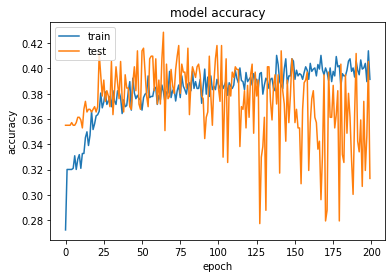

In [52]:
# summarize history for accuracy

plt.plot(h.history['acc'])
plt.plot(h.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

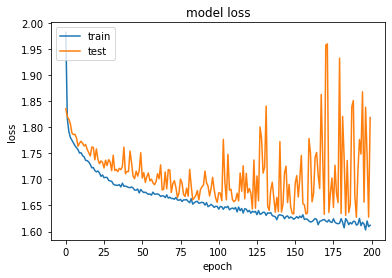

In [53]:
# summarize history for loss

plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [54]:
scores = model.evaluate(X_test_rnn, y_test)
print('IRNN test score:', scores[0])
print('IRNN test accuracy:', scores[1])

476/476 [==============================] - 1s 1ms/step
IRNN test score: 1.8183247772585445
IRNN test accuracy: 0.3130252108353527
